In [13]:
import time

import numpy as np
from scipy import integrate

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Distance, Galactocentric, CartesianRepresentation, SphericalRepresentation

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [3]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

import numpy as np

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)
    
from utils import get_mcconn_table

In [4]:
mcconndat = get_mcconn_table()

#the MW sats
sample = mcconndat['distance']<420
sample[mcconndat['name']=='Canis Major'] = False
sample[mcconndat['name']=='Phoenix'] = False
sample[mcconndat['name']=='Phoenix'] = False
sample[mcconndat['name']=='Sagittarius dSph'] = False  # disrupting

#special-case including some of the bright M31 objects
sample[mcconndat['name']=='M32'] = True
sample[mcconndat['name']=='NGC 147'] = True
sample[mcconndat['name']=='NGC 185'] = True
sample[mcconndat['name']=='NGC 205'] = True

ldat = mcconndat[sample]
ldat

name,center,EBmV,distmod,distmod+,distmod-,vh,vh+,vh-,Vmag,Vmag+,Vmag-,PA,PA+,PA-,e,e+,e-,muV0,muV0+,muV0-,rh,rh+,rh-,sigma_s,sigma_s+,sigma_s-,vrot_s,vrot_s+,vrot_s-,MHI,sigma_g,sigma_g+,sigma_g-,vrot_g,vrot_g+,vrot_g-,[Fe/H],[Fe/H]+,[Fe/H]-,F,References,Vabs,logLV,distance,distance+,distance-,rh_phys,radeg,decdeg,x [106],y [106],z [106],and_number
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,solLum,kpc,kpc,kpc,kpc,deg,deg,kpc,kpc,kpc,
str19,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
Segue (I),"<ICRS Coordinate: (ra, dec) in deg (151.76666667, 16.08194444)>",0.031,16.8,0.2,0.2,208.5,0.9,0.9,15.3,0.8,0.8,85.0,8.0,8.0,0.48,0.13,0.13,27.6,1.0,1.0,4.4,1.2,0.6,3.9,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.72,0.4,0.4,2,(5)(6)(98)(130)(178),-1.5,2.532,22.9086765277,2.10996708291,2.10996708291,0.0293210010634,151.766666667,16.0819444444,-6.10454009929 .. -2498.34810838,3.27779965593 .. 1341.47444965,1.99755331472 .. 817.519987428,-99
Ursa Major II,"<ICRS Coordinate: (ra, dec) in deg (132.875, 63.13)>",0.094,17.5,0.3,0.3,-116.5,1.9,1.9,13.3,0.5,0.5,98.0,4.0,4.0,0.63,0.05,0.05,27.9,0.6,0.6,16.0,1.0,1.0,6.7,1.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.47,0.06,0.06,2,(7)(8)(98)(130)(179)(180),-4.2,3.612,31.6227766017,4.36884804013,4.36884804013,0.147179085419,132.875,63.13,-2.21754506878 .. -907.553957829,2.38845178607 .. 977.499353702,6.43252606578 .. 2632.57986141,-99
Bootes II,"<ICRS Coordinate: (ra, dec) in deg (209.5, 12.85)>",0.031,18.1,0.06,0.06,-117.0,5.2,5.2,15.4,0.9,0.9,145.0,55.0,55.0,0.21,0.21,0.21,28.1,1.6,1.6,4.2,1.4,1.4,10.5,7.4,7.4,99.9,99.9,99.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.79,0.05,0.05,3,(9)(10)(98)(130),-2.7,3.012,41.686938347,1.15185267373,1.15185267373,0.0509302030462,-150.5,12.85,-6.11901664063 .. -2504.27278724,-3.46197304455 .. -1416.84937218,1.60373864575 .. 656.347136196,-99
Segue II,"<ICRS Coordinate: (ra, dec) in deg (34.81666667, 20.17527778)>",0.185,17.7,0.1,0.1,-39.2,2.5,2.5,15.2,0.3,0.3,182.0,17.0,17.0,0.15,0.1,0.1,27.4,0.4,0.4,3.4,0.2,0.2,3.4,2.5,1.2,99.9,99.9,99.9,99.9,99.9,99.9,99.9,999.9,99.9,99.9,-2.22,0.13,0.13,2,(11)(214),-2.5,2.932,34.6736850453,1.59678220609,1.59678220609,0.0342929648442,34.8166666667,20.1752777778,5.55692068545 .. 2274.22902579,3.86455823779 .. 1581.61165396,2.48705081888 .. 1017.85205892,-99
Willman 1,"<ICRS Coordinate: (ra, dec) in deg (162.3375, 51.05)>",0.014,17.9,0.4,0.4,-12.3,2.5,2.5,15.2,0.7,0.7,77.0,5.0,5.0,0.47,0.08,0.08,26.1,0.9,0.9,2.3,0.4,0.4,4.3,2.3,1.3,99.9,99.9,99.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.1,9.99,9.99,2,(12)(13)(98)(130)(181),-2.7,3.012,38.0189396321,7.00334749186,7.00334749186,0.0254363008634,162.3375,51.05,-4.31949112113 .. -1767.79778593,1.3754110679 .. 562.901641048,5.60801573662 .. 2295.14022014,-99
Coma Berenices,"<ICRS Coordinate: (ra, dec) in deg (186.74583333, 23.90416667)>",0.017,18.2,0.2,0.2,98.1,0.9,0.9,14.1,0.5,0.5,115.0,10.0,10.0,0.38,0.14,0.14,27.3,0.7,0.7,6.0,0.6,0.6,4.6,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.6,0.05,0.05,2,(5)(8)(98)(130)(179)(180),-4.1,3.572,43.651583224,4.02045939269,4.02045939269,0.0761863850967,-173.254166667,23.9041666667,-6.54690102446 .. -2679.38903246,-0.774394030261 .. -316.929011716,2.9219857144 .. 1195.8538012,-99
Bootes III,"<ICRS Coordinate: (ra, dec) in deg (209.3, 26.8)>",0.021,18.35,0.1,0.1,197.5,3.8,3.8,12.6,0.5,0.5,90.0,99.9,99.9,0.5,9.99,9.99,31.3,0.3,0.3,99.99,9.99,9.99,14.0,3.2,3.2,99.9,99.9,99.9,99.9,99.9,99.9,99.9,999.9,99.9,99.9,-2.1,0.2,0.2,2,(14)(15)(99),-5.75,4.232,46.7735141287,2.15399992759,2.15399992759,1.36045031515,-150.7,26.8,-5.61307657105 .. -2297.21142058,-3.14991166531 .. -1289.13492624,3.2513

## Trial distances for SAGA-like hosts

In [5]:
sagadists = [5, 10, 20, 30, 35, 42] * u.Mpc
distmods = 5*np.log10(sagadists/(10*u.pc))

# Try basic LG dSph-like things

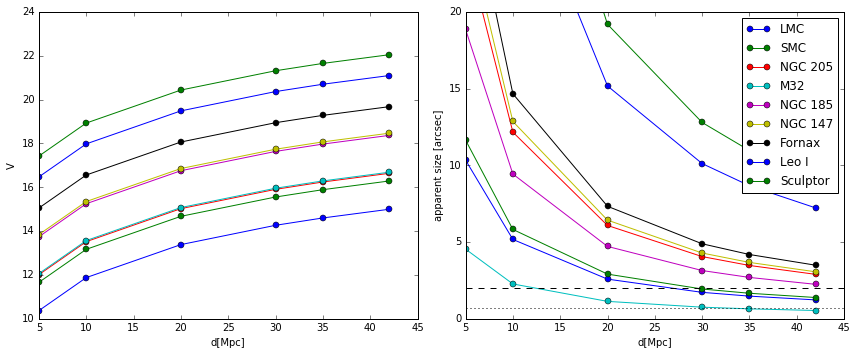

In [6]:
data = ldat[ldat['Vabs']<-10]
data = data[np.argsort(data['Vabs'])]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for gal in data:
    plt.plot(sagadists.value, gal['Vabs']+distmods.value,'-o',label=gal['name'])
plt.xlabel('d[Mpc]')
plt.ylabel('V')

plt.subplot(1,2,2)
for gal in data:
    plt.plot(sagadists.value, ((gal['rh_phys']/sagadists.to(u.kpc).value)*u.rad).to(u.arcsec).value,'-o',label=gal['name'])
plt.xlabel('d[Mpc]')
plt.ylabel('apparent size [arcsec]')
plt.legend(loc=0)
plt.ylim(0,20)
plt.axhline(2, c='k', ls='--')
plt.axhline(0.7, c='k', ls=':')

plt.tight_layout()

1.0
0.5
1.0
0.5


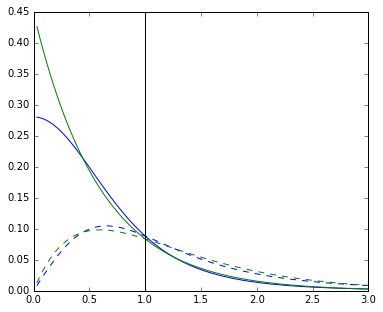

In [7]:
def plummer_prof(r, totflux=1, Reff=1):
    a = Reff*(2**(2/3)-1)**-0.5
    return 2*a*(3 * totflux / (4*np.pi*a**3))*(1+(r/a)**2)**-2.5
def exp_prof(r, totflux=1, Reff=1):
    from scipy.special import lambertw
    #the parenthetical below is non-trivial, but it's ~1.67835
    rs = Reff / -(lambertw(-1/2/np.exp(1),-1).real+1)
    return totflux*np.exp(-r/rs)/np.pi/2./rs/rs
                                     
r = np.linspace(0,3,101)[1:]
plt.figure(figsize=(6,5))

#test that the integrals behave correctly
print integrate.quad(lambda x:plummer_prof(x,1,2.123)*x*np.pi*2,0,np.inf)[0] # should be 1
print integrate.quad(lambda x:plummer_prof(x,1,2.123)*x*np.pi*2,0,2.123)[0] # should be 0.5
print integrate.quad(lambda x:exp_prof(x,1,2.123)*x*np.pi*2,0,np.inf)[0] # should be 1
print integrate.quad(lambda x:exp_prof(x,1,2.123)*x*np.pi*2,0,2.123)[0] # should be 0.5

plt.plot(r, plummer_prof(r,1,1),'b-')
plt.plot(r, exp_prof(r,1,1),'g-');
plt.plot(r, r*plummer_prof(r,1,1),'b--')
plt.plot(r, r*exp_prof(r,1,1),'g--');
plt.axvline(1, c='k')
None

In [8]:
def frac_inside(gal, radius, dist, prof):
    """
    Compute the magnitude inside the given angular `radius` for the
    table entry `gal` at a distance of `dist`, assuming a profile
    `prof` ('plummer' or 'exp')
    """    
    if prof == 'plummer':
        prof_func = plummer_prof
    elif prof == 'exp':
        prof_func = exp_prof
    else:
        raise ValueError('invalid profile type '+ str(prof))
        
    rh_at_distance = (u.arcmin*gal['rh'] * (gal['distance']*u.kpc)/dist).to(u.arcmin)
    return integrate.quad(lambda x:prof_func(x, 1, rh_at_distance.value)*x*np.pi*2, 0, radius.to(u.arcmin).value)[0]

def gal_mag_frac(gal, frac, dist):
    """
    determine the V magnitude for `frac` of the flux from `gal` at distance `dist`
    """
    flux = 10**((gal['Vabs'])/-2.5)
    fluxd = flux * ((10*u.pc/dist)**2).decompose().value
    return -2.5*np.log10(frac*fluxd)
    

/Users/erik/miniconda3/envs/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


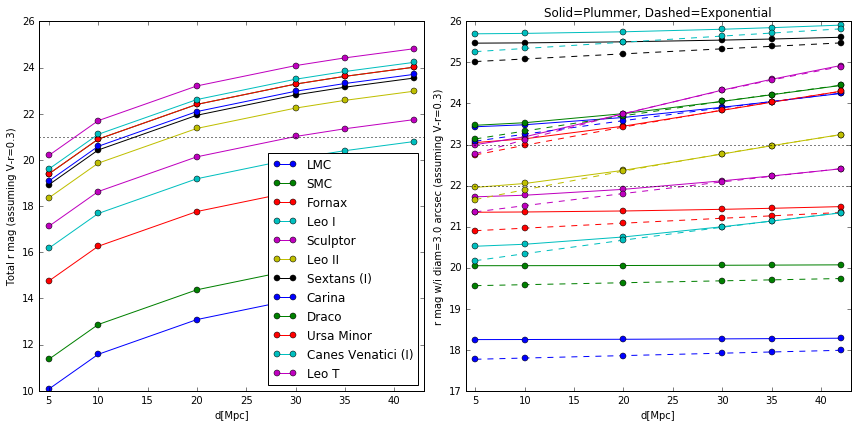

In [9]:
data = ldat[(ldat['Vabs']<-8)&(ldat['distance']<500)]
data = data[np.argsort(data['Vabs'])]
rad = 3*u.arcsec/2 #3" diam = fibermag
Vmr=0.3

plt.figure(figsize=(12,6))

cc = []
for _ in range(5):
    cc.extend(matplotlib.rcParams['axes.color_cycle'])

#first do plummer
for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'plummer') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = gal_mag_frac(gal, np.ones_like(fracs), sagadists) - Vmr
    
    plt.subplot(1,2,1)
    plt.plot(sagadists.value, totmags,'-o',color=cc[i],label=gal['name'])
    
    plt.subplot(1,2,2)
    plt.plot(sagadists.value, fibmags,'-o',color=cc[i],label=gal['name'])
    
plt.subplot(1,2,1)
plt.legend(loc=0)
    
#now exp
for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'exp') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = gal_mag_frac(gal, np.ones_like(fracs), sagadists) - Vmr
    
    #plt.subplot(1,2,1)
    #plt.plot(sagadists.value, totmags,'-o',color=cc[i],label=gal['name'])
    
    plt.subplot(1,2,2)
    plt.plot(sagadists.value, fibmags,'--o',color=cc[i],label=gal['name'])
    
plt.subplot(1,2,1)
plt.xlabel('d[Mpc]')
plt.ylabel('Total r mag (assuming V-r={1})'.format(rad*2, Vmr))
plt.xlim(4,43)
plt.axhline(21, c='k', ls=':')

plt.subplot(1,2,2)
plt.xlabel('d[Mpc]')
plt.ylabel('r mag w/i diam={0} (assuming V-r={1})'.format(rad*2, Vmr))
plt.xlim(4,43)
plt.axhline(22, c='k', ls=':')
plt.axhline(23, c='k', ls=':')
plt.title('Solid=Plummer, Dashed=Exponential')

plt.tight_layout()

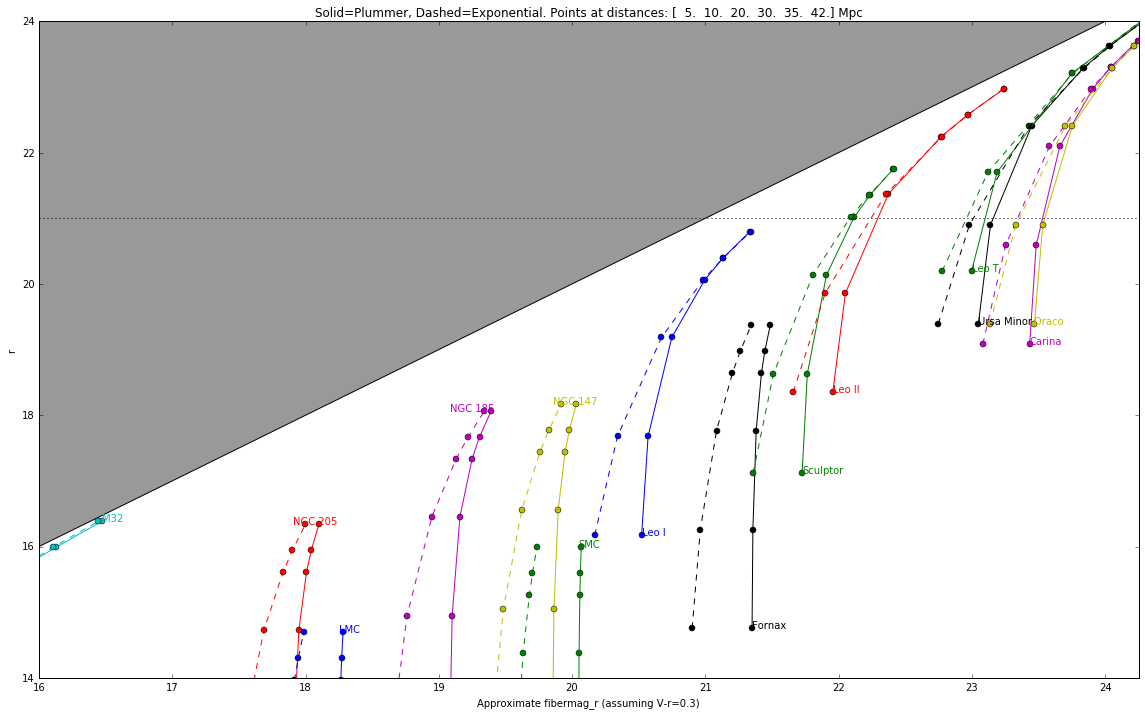

In [15]:
#matched to similar plot in 2014May-MMTHecto
data = ldat[(ldat['Vabs']<-8)&(ldat['distance']<5000)]
data = data[np.argsort(data['Vabs'])]
rad = 3*u.arcsec/2 #3" diam = fibermag
Vmr=0.3

fiblim = (16, 24)
totlim = (14, 24)

cc = []
for _ in range(5):
    cc.extend(matplotlib.rcParams['axes.color_cycle'])

#first do plummer
for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'plummer') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = gal_mag_frac(gal, np.ones_like(fracs), sagadists) - Vmr
    
    plt.plot(fibmags, totmags,'-o',color=cc[i],label=gal['name'])
    
    f0 = fiblim[0] < fibmags[0] < fiblim[1]
    fm1 = fiblim[0] < fibmags[-1] < fiblim[1]
    t0 = totlim[0] < totmags[0] < totlim[1]
    tm1 = totlim[0] < totmags[-1] < totlim[1]
    fi = ti = None
    if f0:
        fi=0
        if t0:
            ti=0
        elif tm1:
            ti=-1
    elif fm1:
        fi=-1
        if t0:
            ti=0
        elif tm1:
            ti=-1
    if fi is not None and ti is not None:
        plt.text(fibmags[fi], totmags[ti], gal['name'],color=cc[i])
#plt.legend(loc=0)

for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'exp') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = gal_mag_frac(gal, np.ones_like(fracs), sagadists) - Vmr
    
    plt.plot(fibmags, totmags,'--o',color=cc[i],label=gal['name'])
    
x1t1 = [min(fiblim[0], totlim[0]), max(fiblim[1], totlim[1])]
plt.fill_between(x1t1,x1t1, totlim[1],facecolor=[0.6]*3)
plt.axhline(21, c='k', ls=':')
    
plt.xlabel('Approximate fibermag_r (assuming V-r={0})'.format(Vmr))
plt.ylabel('r')
plt.title('Solid=Plummer, Dashed=Exponential. Points at distances: {0}'.format(sagadists))
plt.xlim(fiblim[0], fiblim[1]+.25) #tweak for text
plt.ylim(*totlim)
plt.tight_layout()

## Now try similar plots, but with SAGA data on them

In [14]:
clean = Table.read('SAGADropbox/data/saga_spectra_clean_jan15.fits.gz')
dirty = Table.read('SAGADropbox/data/saga_spectra_dirty_jan15.fits.gz')
sats = clean[clean['SATS']==1]
sats.show_in_notebook(display_length=5)

OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,SATURATED,BAD_COUNTS_ERROR,BINNED1,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,Column1,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPECOBJID,SPEC_REPEAT
1237655693015056396,224.532617519,-1.31259609568,3,GALAXY,35253360398352,262144,0,268435456,17.3497,16.089,15.4546,15.1464,14.9615,0.0416732,0.00498512,0.00534471,0.00545955,0.0135447,0.0416732,0.00498512,0.00534471,0.00545955,0.0135447,0.32708,0.240662,0.174548,0.132355,0.0938412,17.1418,15.8741,15.3876,15.0828,14.9173,12.9075,13.4682,13.1628,13.8231,13.8238,0.738636,0.710056,0.803463,0.78797,0.894669,21.15,3.11296,24.4211,0.411017,23.5287,0.513989,23.8198,0.408222,24.1926,1.04576,0.449992,0.465957,0.446009,0.475622,0.467311,17.477,0.0415375,16.0842,0.00498177,15.5622,0.00534471,15.1929,0.00545646,15.0088,0.0135404,21.1691,0.0788425,19.6741,0.0184681,19.4228,0.0195905,19.0933,0.019701,18.8251,0.037165,20.6698,0.0618124,19.3683,0.0111833,18.7532,0.0087296,18.4167,0.00977192,18.174,0.0217943,0.0,0.0,0.0,0.0,0.0,0.0862015,-0.015842,0.139541,-0.0327954,0.14517,-0.0385242,0.135794,-0.034536,0.133919,-0.0334079,0.508928,8.21412,149.518,0.479386,8.81146,151.674,0.473689,8.55776,152.901,0.487392,8.70547,151.876,0.495454,8.42529,152.167,19.5874,0.0125185,15.5622,0.00534471,8.55776,6.02391,13.3899,15.5966,22.2194214691,21.4913916271,15.174,9999.0,15.71,0.248,14.45,9999.0,0.0064927,2.15047e-05,0,0.067474,0.016437,-1.0,-1.0,-1.0,-1.0,224.594,-1.09102,28.4038,1922.0,7.693,145729,0,,13.7934861167,113.96603527,35536,1,0.559135409723,0.691219228277,-1,NSA,sdss,4,1.23765569302e+18,NSA
1237648702984683605,225.005401226,-1.09130226734,3,GALAXY,1161121054724696,0,0,268435456,16.0611,15.3154,14.9987,14.8723,14.7438,0.00790307,0.00274512,0.00320407,0.00445661,0.00904204,0.00790307,0.00274512,0.00320407,0.00445661,0.00904204,0.327712,0.241128,0.174886,0.132611,0.0940226,15.997,15.1689,14.8268,14.7113,14.6349,40.986,12.9685,13.7948,14.3383,13.7471,1.52479,0.171283,0.158666,0.162538,0.28877,10.7435,0.29789,14.1078,0.139925,15.0666,0.189859,16.1199,0.217477,19.1789,0.55349,0.763178,0.837018,0.889757,0.903721,0.889412,16.1489,0.00772101,15.3572,0.00280809,14.9363,0.00327976,14.7643,0.00451928,14.6683,0.00921106,18.9691,0.0220671,18.7247,0.0217491,18.3088,0.0183036,18.6214,0.0184466,18.4012,0.0271797,18.6917,0.0133083,18.1511,0.00473336,17.9322,0.00489516,17.876,0.00606622,17.7374,0.015826,0.707669,0.186364,0.135334,0.0759754,0.0475266,0.049303,0.0401041,0.0350942,0.0156222,0.021055,0.00853904,0.0190857,0.00764772,0.0257252,0.000878967,0.766903,4.61793,19.3252,0.859923,6.01446,14.5641,0.9152,6.17972,15.5966,0.893827,6.821,16.

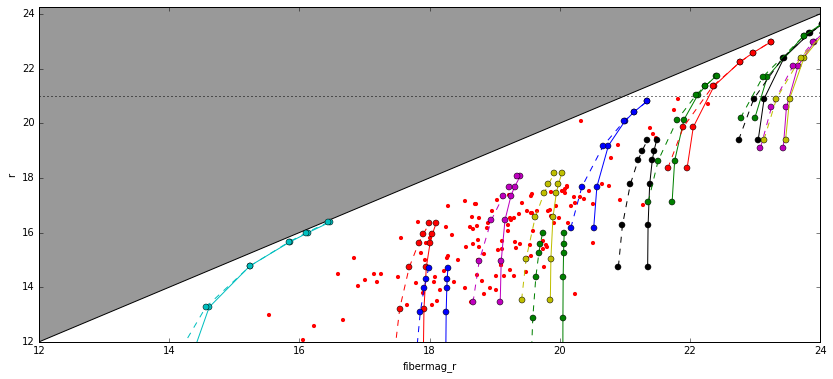

In [26]:
plt.figure(figsize=(14,6))

fiblim = (12, 24)
totlim = (12, 24.25)

x1t1 = [min(fiblim[0], totlim[0]), max(fiblim[1], totlim[1])]
plt.fill_between(x1t1,x1t1, totlim[1],facecolor=[0.6]*3)
plt.axhline(21, c='k', ls=':')

cc = []
for _ in range(5):
    cc.extend(matplotlib.rcParams['axes.color_cycle'])

#first do plummer
for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'plummer') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = gal_mag_frac(gal, np.ones_like(fracs), sagadists) - Vmr
    
    plt.plot(fibmags, totmags,'-o',color=cc[i],label=gal['name'])
    
    f0 = fiblim[0] < fibmags[0] < fiblim[1]
    fm1 = fiblim[0] < fibmags[-1] < fiblim[1]
    t0 = totlim[0] < totmags[0] < totlim[1]
    tm1 = totlim[0] < totmags[-1] < totlim[1]
    fi = ti = None
    if f0:
        fi=0
        if t0:
            ti=0
        elif tm1:
            ti=-1
    elif fm1:
        fi=-1
        if t0:
            ti=0
        elif tm1:
            ti=-1

for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'exp') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = gal_mag_frac(gal, np.ones_like(fracs), sagadists) - Vmr
    
    plt.plot(fibmags, totmags,'--o',color=cc[i],label=gal['name'])


#real data

plt.scatter(sats['FIBERMAG_R'], sats['r'], color='r',s=10)
plt.xlim(*fiblim)
plt.ylim(*totlim)

plt.xlabel('fibermag_r')
plt.ylabel('r')

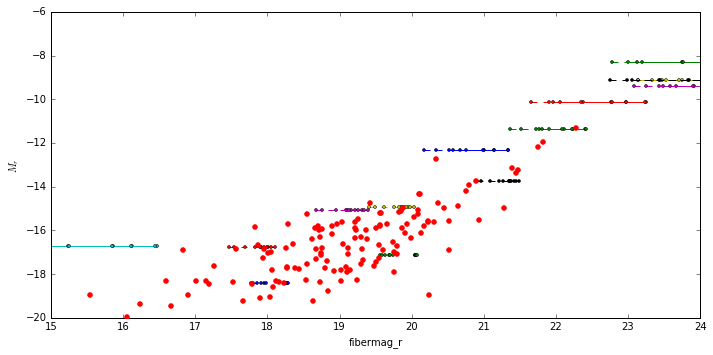

In [68]:
# and absolute magnitudes
plt.figure(figsize=(10,5))

fiblim = (15, 24)
totlim = (-20, -6)

#simulated
for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'plummer') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = np.ones_like(fracs)*gal['Vabs'] - Vmr
    
    plt.plot(fibmags, totmags,'-o',color=cc[i],label=gal['name'], ms=3)
    
    f0 = fiblim[0] < fibmags[0] < fiblim[1]
    fm1 = fiblim[0] < fibmags[-1] < fiblim[1]
    t0 = totlim[0] < totmags[0] < totlim[1]
    tm1 = totlim[0] < totmags[-1] < totlim[1]
    fi = ti = None
    if f0:
        fi=0
        if t0:
            ti=0
        elif tm1:
            ti=-1
    elif fm1:
        fi=-1
        if t0:
            ti=0
        elif tm1:
            ti=-1

for i, gal in enumerate(data):
    fracs = np.array([frac_inside(gal, rad, dist, 'exp') for dist in sagadists])
    fibmags = gal_mag_frac(gal, fracs, sagadists) - Vmr
    totmags = np.ones_like(fracs)*gal['Vabs'] - Vmr 
    plt.plot(fibmags, totmags,'--o',color=cc[i],label=gal['name'], ms=3)


# now the actual SAGA data
dists = Distance(sats['HOST_DIST']*u.Mpc)
Mr = sats['r'] - dists.distmod.value

plt.scatter(sats['FIBERMAG_R'], Mr, color='r',s=20, zorder=10)


plt.xlim(*fiblim)
plt.ylim(*totlim)
plt.xlabel('fibermag_r')
plt.ylabel('$M_r$')

plt.tight_layout()

# Simulated images with specific LG-dwarf like gals 

The data for the LG dwarf stars here are from Ricardo Munoz and are not yet public so the data are not in the repo.  If you want to reproduce these feel free to check with Ricardo or Erik.

In [11]:
fnx = Table.read('lg_dwarfs/fornax_erik.erad', format='ascii.commented_header', guess=False, header_start=2)
leoi = Table.read('lg_dwarfs/leoi_erik.erad', format='ascii.commented_header', guess=False, header_start=2)
scl = Table.read('lg_dwarfs/scl_erik.erad', format='ascii.commented_header', guess=False, header_start=2)

fnx.colnames

['id',
 'ra',
 'dec',
 'g',
 'gerr',
 'r',
 'rerr',
 'chi',
 'sharp',
 'rd',
 'l',
 'b',
 'egr',
 'ag',
 'ar']

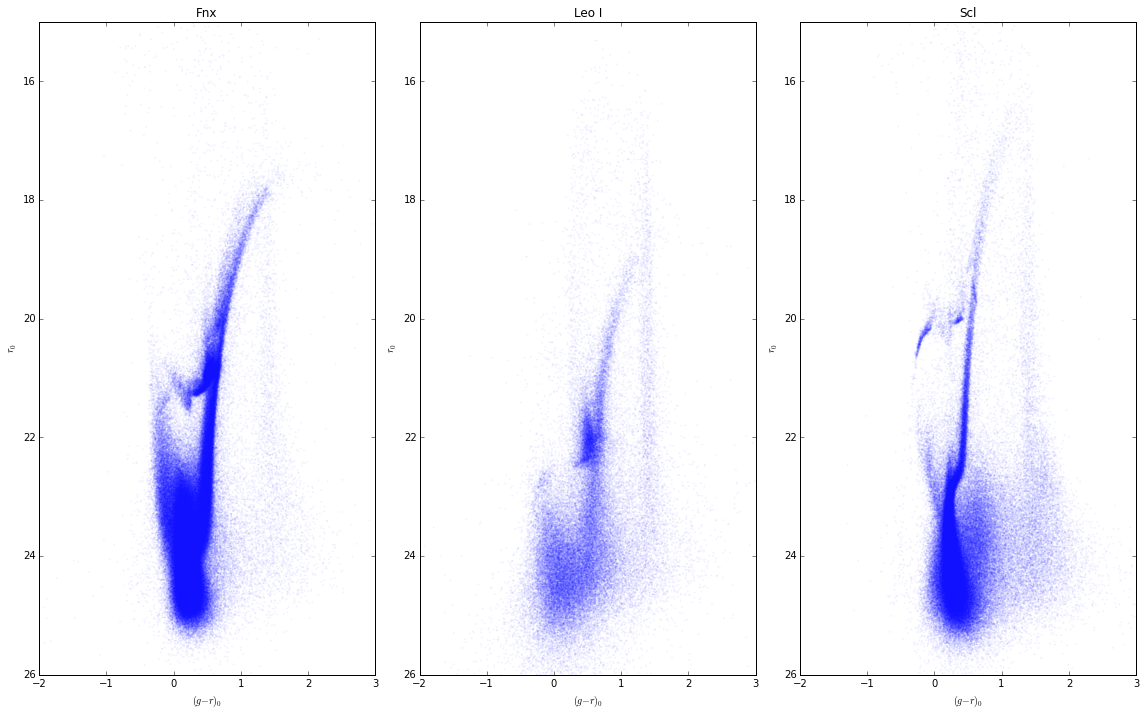

In [13]:
def plot_cmd(tab, plkwargs):
    plt.scatter(tab['g']-tab['r']-tab['egr'], tab['r']-tab['ar'], **plkwargs)
    plt.xlim(-2,3)
    plt.ylim(26,15)
    plt.xlabel('$(g-r)_0$')
    plt.ylabel('$r_0$')
    plt.tight_layout()

plkwargs = dict(alpha=.05,edgecolor='none', s=4)
plt.subplot(1,3,1)
plot_cmd(fnx, plkwargs)
plt.title('Fnx')
plt.subplot(1,3,2)
plot_cmd(leoi, plkwargs)
plt.title('Leo I')
plt.subplot(1,3,3)
plot_cmd(scl, plkwargs)
plt.title('Scl')

plt.tight_layout()

##  Define cython code for computationally-expensive bits

In [17]:
%load_ext Cython

In [18]:
%%cython -a

import cython
import numpy as np
from libc.math cimport exp

cdef double PI = 3.141592653589793

@cython.cdivision(True) 
cdef inline double ngauss2d(double x, double y, double sig):
    cdef double tsigsq = 2.0*sig*sig
    return exp(-(x*x + y*y)/tsigsq)/(tsigsq * PI)

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
cpdef convolve(data, xgrid, ygrid, fluxes, cenx, ceny, fwhm):
    from math import log
    import time
    
    cdef double[:, :] data_view = data
    cdef double[:, :] xgrid_view = xgrid
    cdef double[:, :] ygrid_view = ygrid
    cdef double[:] fluxes_view = fluxes
    cdef double[:] cenx_view = cenx
    cdef double[:] ceny_view = ceny
    
    cdef int I, J, S
    cdef double sig = fwhm/(2*(2*log(2))**0.5)
    cdef double starflux, starx, stary, dx, dy
    
    I = data.shape[0]
    J = data.shape[1]
    S = fluxes.shape[0]
    
    for s in range(S):
        starflux = fluxes_view[s]
        starx = cenx_view[s]
        stary = ceny_view[s]
        
        for i in range(I):
            for j in range(J):
                dx = starx + xgrid_view[i, j]
                dy = stary + ygrid_view[i, j]
                data_view[i,j] += starflux * ngauss2d(dx, dy, sig)

## Experiment with Fornax

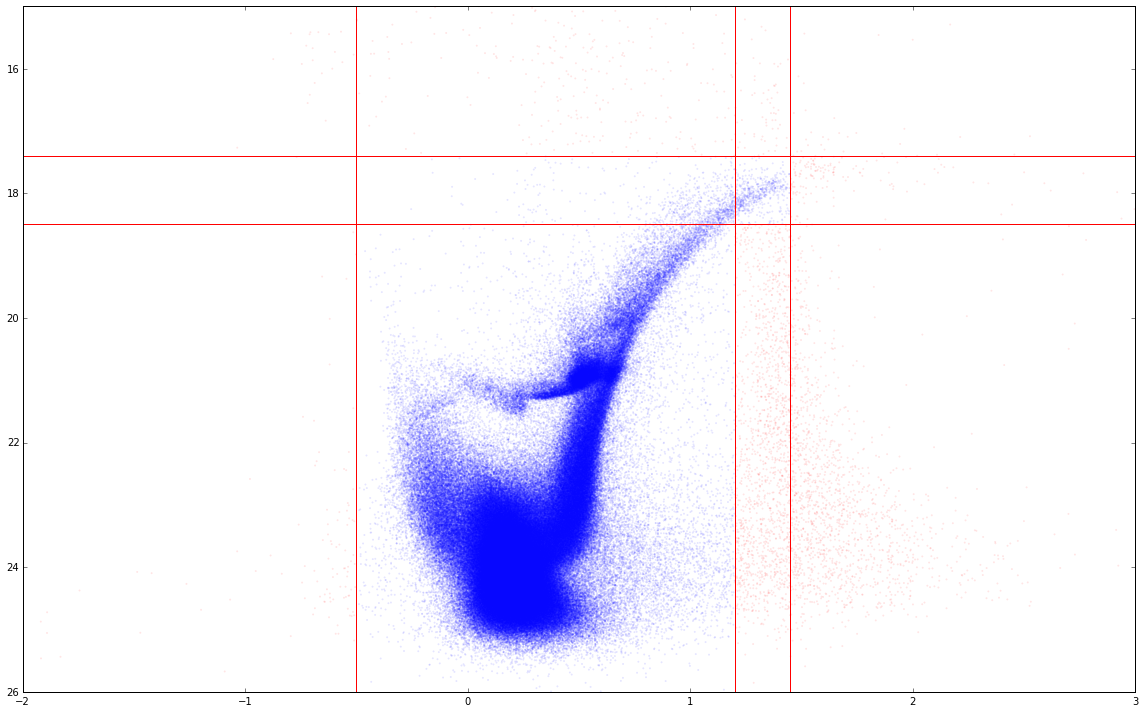

In [15]:
tab = fnx
x = tab['g']-tab['r']-tab['egr']
y = tab['r']-tab['ar']


#first the larger box
maxmag = 17.4
colorrng = (-.5, 1.45)
fnxmsk = (colorrng[0]<x)&(x<colorrng[1])&(y>maxmag)

#now eliminate the MW inset
insetcolor = 1.2
insetmag = 18.5
fnxmsk[(x>insetcolor)&(y>insetmag)] = False


plt.scatter(x[fnxmsk], y[fnxmsk], alpha=.1,edgecolor='none', s=4, color='b')
plt.scatter(x[~fnxmsk], y[~fnxmsk], alpha=.1,edgecolor='none', s=4, color='r')

plt.axhline(maxmag, color='r')
plt.axvline(colorrng[0], color='r')
plt.axvline(colorrng[1], color='r')

plt.axhline(insetmag, color='r')
plt.axvline(insetcolor, color='r')

plt.xlim(-2,3)
plt.ylim(26,15)
plt.tight_layout()

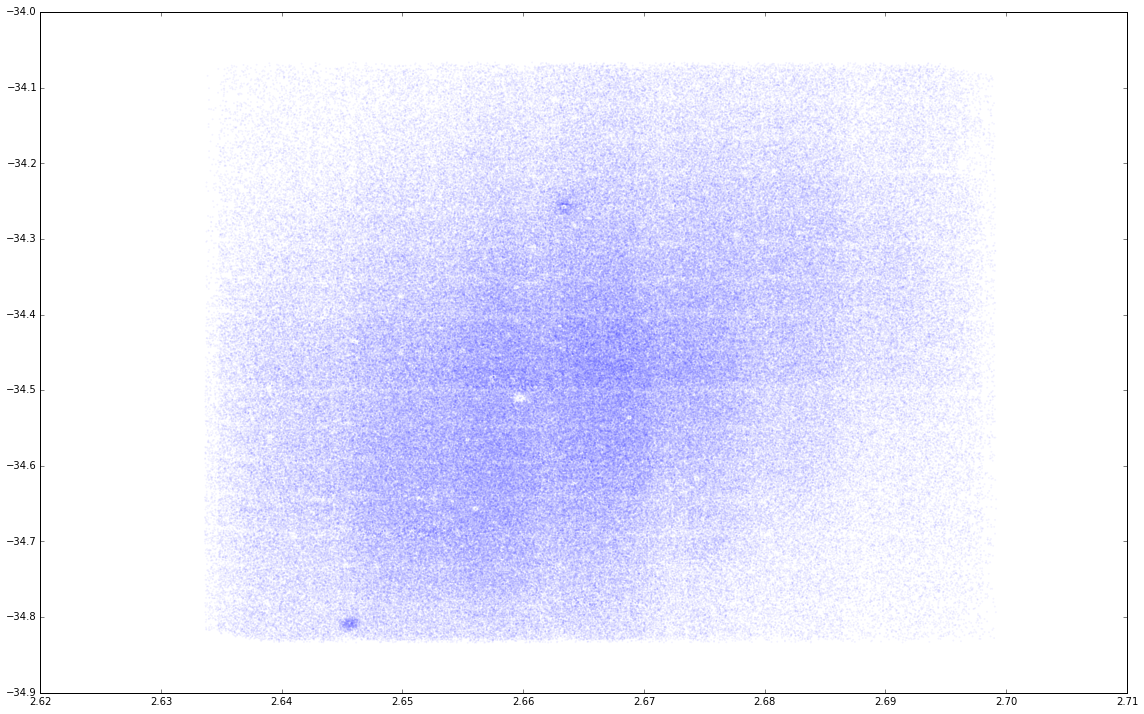

In [14]:
plt.scatter(fnx['ra'], fnx['dec'], alpha=.05, edgecolor='none', s=4)
plt.tight_layout()

In [250]:
pixel_scale = 0.396*u.arcsec/u.pixel # SDSS imager
image_size = 1*u.arcmin #on a side

seeing_fwhm = 1.43*u.arcsec #median for DR7 imaging - http://classic.sdss.org/dr7/products/general/seeing.html

sky_brightness = 20.86 * u.mag * u.arcsec**-2 #SDSS r-band median -  - http://classic.sdss.org/dr7/products/general/seeing.html
inst_zeropoint = 28.2 *u.mag #mag corresponding to 1 DN/sec. this is ~r-band for SDSS DR7 based on .005 NMGYpercount
exposure_time = 59.3*u.second #SDSS
readnoise_cnts = 0

In [251]:
# just assume *all* the stars are members for now
#fnxcoo = SkyCoord.from_name('Fornax dSph')
fnx_coo = SkyCoord(39.99708*u.deg, -34.44917*u.deg)
fnx_dist = u.Quantity(ldat[ldat['name'] == 'Fornax']['distance'])[0]

fnx_galactocentric = Galactocentric(galcen_distance=fnx_dist, galcen_ra=fnx_coo.ra, galcen_dec=fnx_coo.dec,z_sun=0*u.kpc)
fnxstars_coo = SkyCoord(fnx['ra']*u.hourangle, fnx['dec']*u.deg, distance=fnx_dist).transform_to(fnx_galactocentric)
fnxstars_at_sagadists = [SkyCoord(CartesianRepresentation(x=fnxstars_coo.x+dist, y=fnxstars_coo.y, z=fnxstars_coo.z)) for dist in sagadists]

In [252]:
i = -1

imsize = np.ceil((image_size/pixel_scale).to(u.pix).value)
xg, yg = np.mgrid[-image_size/2:image_size/2:imsize*1j, -image_size/2:image_size/2:imsize*1j] * image_size.unit
fakeimagenosky = np.zeros(xg.shape)

rflux = 10**((fnx['r'] - fnx['ar'])/-2.5)
msk = np.random.permutation(np.where(fnxmsk)[0])[:40000]

star_dra = fnxstars_at_sagadists[i].ra.wrap_at(180*u.deg)
star_ddec = fnxstars_at_sagadists[i].dec.wrap_at(180*u.deg)

st = time.time()
convolve(fakeimagenosky, xg, yg, rflux[msk], star_dra.arcmin[msk], star_ddec.arcmin[msk], seeing_fwhm.to('arcmin').value)
print(time.time()-st, 'sec for', np.sum(msk), 'stars')

# correct for distance
distance_factor=((sagadists[i]/fnx_dist)**-2).decompose().value
# and pixel size
dxdy = (np.mean(np.diff(xg[:,0])).value * np.mean(np.diff(yg[0])).value)*xg.unit*yg.unit
fakeimagenosky *= dxdy.value*distance_factor*(np.sum(fnxmsk)/len(msk))

skyflux = u.arcsec**-2*10**(sky_brightness/(u.mag*u.arcsec**-2)/-2.5)
skyfluxperpixel = (skyflux*dxdy).decompose()
fakeimage = fakeimagenosky + skyfluxperpixel.value

(16.249601125717163, 'sec for', 10409377925, 'stars')


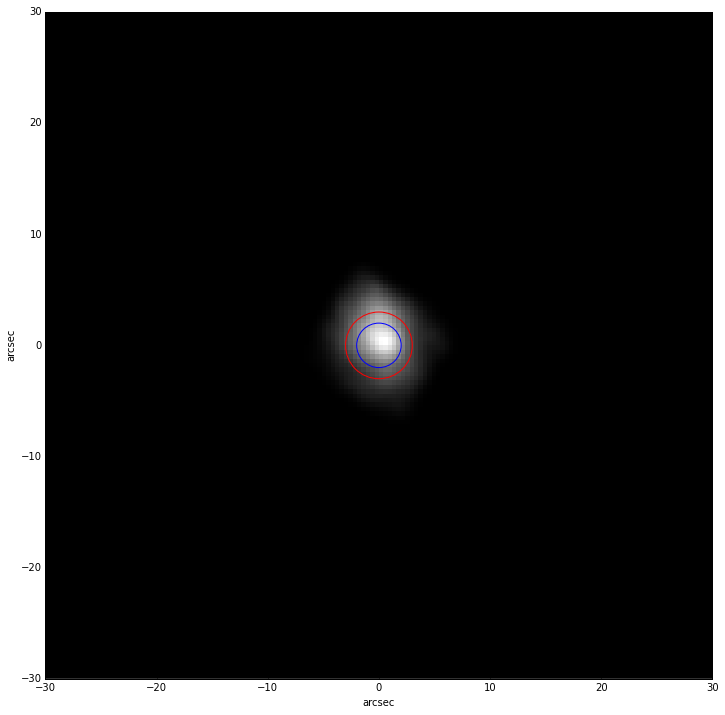

In [253]:
imunit = u.arcsec
extent = (xg.to(imunit).value.min(), xg.to(imunit).value.max(), 
          yg.to(imunit).value.min(), yg.to(imunit).value.max())
plt.imshow(fakeimage, extent=extent, cmap='gray')

plt.gca().add_patch(plt.Circle((0, 0), radius=(2*u.arcsec).to(imunit).value, edgecolor='b', facecolor='none'))
plt.gca().add_patch(plt.Circle((0, 0), radius=(3*u.arcsec).to(imunit).value, edgecolor='r', facecolor='none'))

plt.xlabel(str(imunit))
plt.ylabel(str(imunit))
plt.tight_layout()

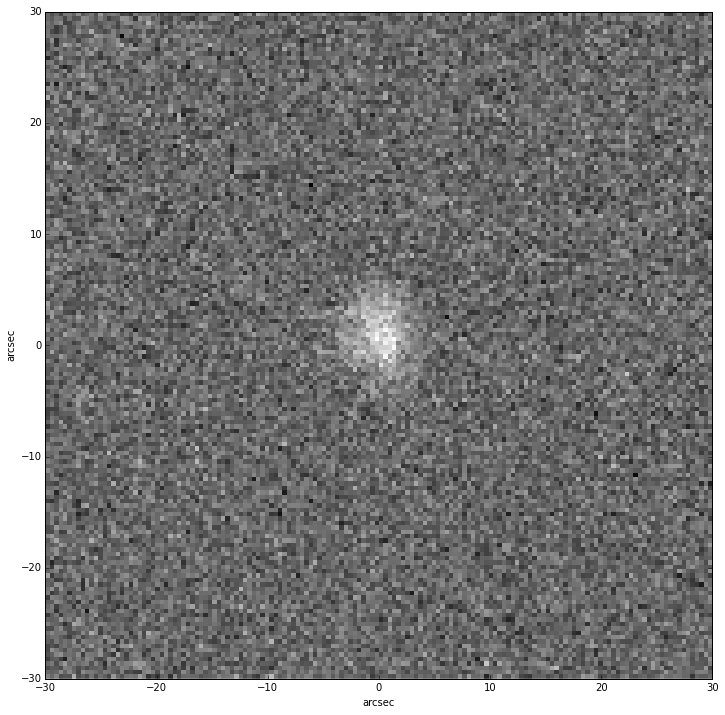

In [254]:
#poissonified
pfakeimage = np.random.poisson(exposure_time/u.second*fakeimage*10**(inst_zeropoint/(2.5*u.mag)))
pfakeimage += np.random.randn(*fakeimage.shape)*readnoise_cnts # read noise

imunit = u.arcsec
extent = (xg.to(imunit).value.min(), xg.to(imunit).value.max(), 
          yg.to(imunit).value.min(), yg.to(imunit).value.max())
plt.imshow(pfakeimage, extent=extent, cmap='gray')

#plt.gca().add_patch(plt.Circle((0, 0), radius=(2*u.arcsec).to(imunit).value, edgecolor='b', facecolor='none'))
#plt.gca().add_patch(plt.Circle((0, 0), radius=(3*u.arcsec).to(imunit).value, edgecolor='r', facecolor='none'))

plt.xlabel(str(imunit))
plt.ylabel(str(imunit))
plt.tight_layout()

In [255]:
sep = np.hypot(xg, yg).value*xg.unit
totmag = -2.5*np.log10(np.sum(fakeimagenosky))
fibermag2 = -2.5*np.log10(np.sum(fakeimagenosky[sep < 2*u.arcsec]))
fibermag3 = -2.5*np.log10(np.sum(fakeimagenosky[sep < 3*u.arcsec]))
totmag, fibermag2, fibermag3, totmag-fibermag2, totmag-fibermag3

(20.317312215648183,
 21.608086692009167,
 20.980555437629885,
 -1.2907744763609834,
 -0.66324322198170194)

In [256]:
#double- check that flux is conserved
totmag, -2.5*np.log10(np.sum(rflux[msk]))

(20.317312215648183, 10.823480578226622)

In [257]:
sep = np.hypot(xg, yg).value*xg.unit
totmag = -2.5*np.log10(np.sum(fakeimage))
fibermag2 = -2.5*np.log10(np.sum(fakeimage[sep < 2*u.arcsec]))
fibermag3 = -2.5*np.log10(np.sum(fakeimage[sep < 3*u.arcsec]))
totmag, fibermag2, fibermag3, totmag-fibermag2, totmag-fibermag3

(11.954420014859119,
 18.064082188736595,
 17.192285883944148,
 -6.1096621738774761,
 -5.237865869085029)

# "Production"-level based on above experiments

In [296]:
def simulate_dwarf(starcat, 
                   center,
                   realdistance,
                   simdistance,
                   catmsk = None,
                   mag='r',
                   pixel_scale = 0.396*u.arcsec/u.pixel, # SDSS imager
                   image_size = 1*u.arcmin, #on a side
                   seeing_fwhm = 1.43*u.arcsec, #median for DR7 imaging - http://classic.sdss.org/dr7/products/general/seeing.html
                   sky_brightness = 20.86 * u.mag * u.arcsec**-2, #SDSS r-band median -  - http://classic.sdss.org/dr7/products/general/seeing.html
                   inst_zeropoint = 28.2 *u.mag, #mag corresponding to 1 DN/sec. this is ~r-band for SDSS DR7 based on .005 NMGYpercount
                   exposure_time = 59.3*u.second, #SDSS
                   readnoise = 0*u.count,
                   maxstars=10000,  #maximum stars to simulate
                   verbose=True):
    galactocentric = Galactocentric(galcen_distance=realdistance, galcen_ra=center.ra, galcen_dec=center.dec,z_sun=0*u.kpc)
    gcoo = SkyCoord(starcat['ra']*u.hourangle, starcat['dec']*u.deg, distance=realdistance).transform_to(galactocentric)
    stars_at_simdist = SkyCoord(CartesianRepresentation(x=gcoo.x + simdistance, y=gcoo.y, z=gcoo.z))

    imsize = np.ceil((image_size/pixel_scale).to(u.pix).value)
    xg, yg = np.mgrid[-image_size/2:image_size/2:imsize*1j, -image_size/2:image_size/2:imsize*1j] * image_size.unit
    fakeimagenosky = np.zeros(xg.shape)

    rflux = 10**((starcat['r'] - starcat['ar'])/-2.5)
    if catmsk is None:
        catmsk = np.ones(len(starcat), dtype=bool)
    idxs = np.random.permutation(np.where(catmsk)[0])[:maxstars]

    star_dra = stars_at_simdist.ra.wrap_at(180*u.deg)
    star_ddec = stars_at_simdist.dec.wrap_at(180*u.deg)

    st = time.time()
    convolve(fakeimagenosky, xg, yg, rflux[idxs], star_dra.arcmin[idxs], star_ddec.arcmin[idxs], seeing_fwhm.to('arcmin').value)
    if verbose:
        print(time.time()-st, 'sec for', len(idxs), 'stars')

    # correct for distance
    distance_factor=((simdistance/realdistance)**-2).decompose().value

    # and pixel size
    dxdy = (np.mean(np.diff(xg[:,0])).value * np.mean(np.diff(yg[0])).value)*xg.unit*yg.unit
    fakeimagenosky *= dxdy.value*distance_factor*(np.sum(catmsk)/len(idxs))

    skyflux = u.arcsec**-2*10**(sky_brightness/(u.mag*u.arcsec**-2)/-2.5)
    skyfluxperpixel = (skyflux*dxdy).decompose()
    fakeimage = fakeimagenosky + skyfluxperpixel.value

    #poissonified
    pfakeimage = np.random.poisson(exposure_time/u.second*fakeimage*10**(inst_zeropoint/(2.5*u.mag)))
    pfakeimage += np.random.randn(*fakeimage.shape)*readnoise_cnts # read noise

    return pfakeimage, fakeimage, fakeimagenosky, (xg, yg)

def show_fakeimage(img, xg, yg, imunit=u.arcsec, circles=[2*u.arcsec, 3*u.arcsec], mag=False, **kwargs):
    extent = (xg.to(imunit).value.min(), xg.to(imunit).value.max(), 
              yg.to(imunit).value.min(), yg.to(imunit).value.max())
    
    kwargs.setdefault('extent', extent)
    kwargs.setdefault('cmap', 'gray')
    if mag:
        img = -2.5*np.log10(img)
    plt.imshow(img, **kwargs)
    
    if circles is None:
        circles = []
    for rad in circles:
        plt.gca().add_patch(plt.Circle((0, 0), radius=rad.to(imunit).value, edgecolor='r', facecolor='none'))
    
    plt.xlabel(str(imunit))
    plt.ylabel(str(imunit))
    
def aperture_mags(img, apertures=[2*u.arcsec, 3*u.arcsec]):
    sep = np.hypot(xg, yg).value*xg.unit
    
    totmag = -2.5*np.log10(np.sum(img))
    apmags = np.array([-2.5*np.log10(np.sum(img[sep < ap])) for ap in apertures])
    return totmag, apmags, apmags-totmag

###  Test w/ Fornax to reproduce above

In [303]:
pfakeimage, fakeimage, fakeimagenosky, (xg, yg) = simulate_dwarf(fnx, fnx_coo, fnx_dist, sagadists[-1], fnxmsk)

(3.9524190425872803, 'sec for', 10000, 'stars')


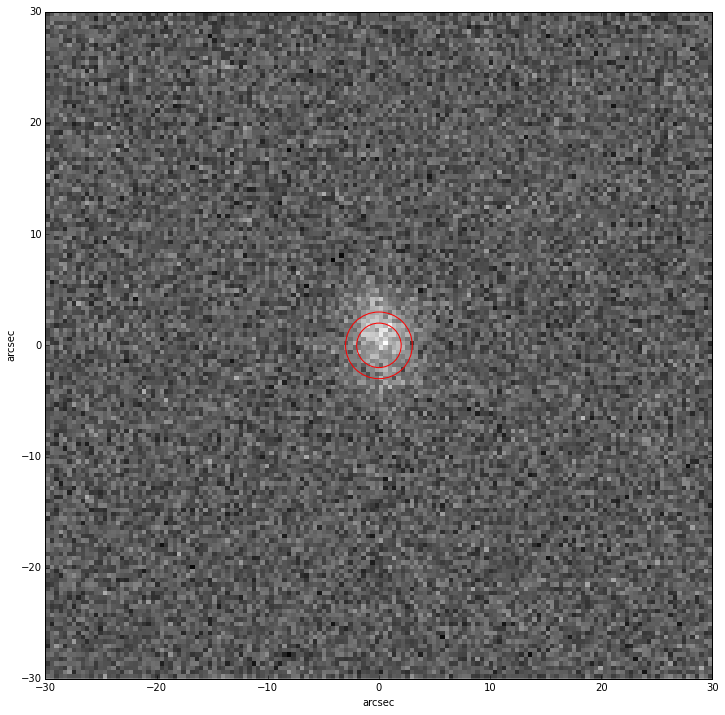

In [304]:
show_fakeimage(pfakeimage, xg, yg)
plt.tight_layout()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10


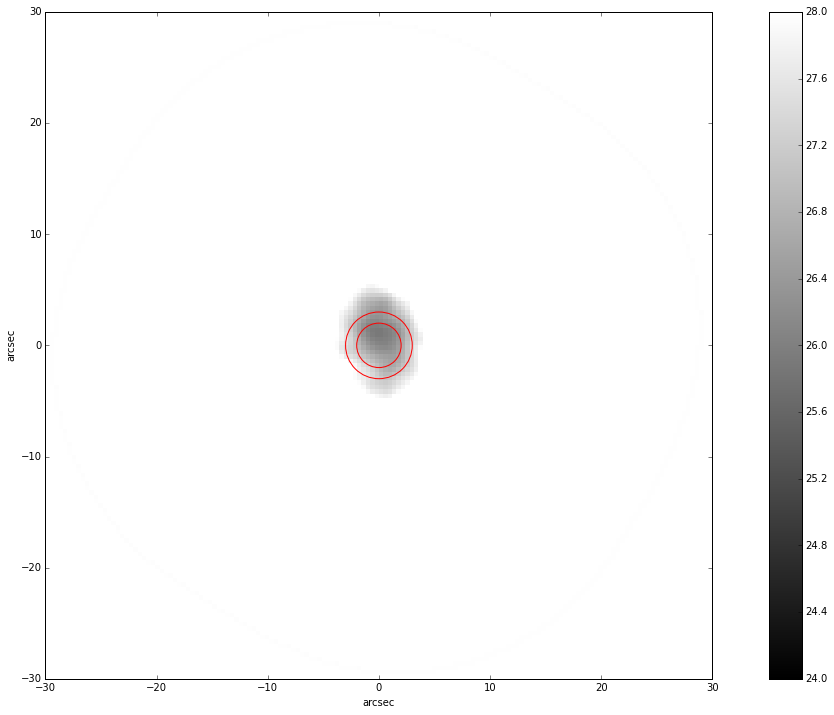

In [305]:
show_fakeimage(fakeimagenosky, xg, yg, mag=True,vmin=24,vmax=28)
plt.colorbar()
plt.tight_layout()

In [306]:
aperture_mags(fakeimagenosky)

(20.285793413994725,
 array([ 21.57214877,  20.93191031]),
 array([ 1.28635535,  0.6461169 ]))

### Now simulate all 

In [309]:
fnx_coo = SkyCoord.from_name('Fornax dSph')
scl_coo = SkyCoord.from_name('Sculptor dSph')
leoi_coo = SkyCoord.from_name('Leo I dSph')

fnx_dist = u.Quantity(ldat[ldat['name'] == 'Fornax']['distance'])[0]
scl_dist = u.Quantity(ldat[ldat['name'] == 'Sculptor']['distance'])[0]
leoi_dist = u.Quantity(ldat[ldat['name'] == 'Leo I']['distance'])[0]

(3.8257431983947754, 'sec for', 10000, 'stars')
Fornax @ 30.0 Mpc aperture phot:(19.561656862219444, array([ 21.45943813,  20.73543203]), array([ 1.89778127,  1.17377517]))
(3.8727328777313232, 'sec for', 10000, 'stars')
Sculptor @ 30.0 Mpc aperture phot:(20.88634585239766, array([ 22.18143815,  21.6340071 ]), array([ 1.2950923 ,  0.74766125]))
(3.8812248706817627, 'sec for', 10000, 'stars')
Leo I @ 30.0 Mpc aperture phot:(19.758481460908261, array([ 21.41017791,  21.05231731]), array([ 1.65169645,  1.29383585]))
(3.9598288536071777, 'sec for', 10000, 'stars')
Fornax @ 35.0 Mpc aperture phot:(19.953183080100303, array([ 21.46229353,  20.8324072 ]), array([ 1.50911045,  0.87922412]))
(3.9839558601379395, 'sec for', 10000, 'stars')
Sculptor @ 35.0 Mpc aperture phot:(21.094637731443832, array([ 22.42789451,  21.9975702 ]), array([ 1.33325678,  0.90293247]))
(4.132309198379517, 'sec for', 10000, 'stars')
Leo I @ 35.0 Mpc aperture phot:(20.167389478526211, array([ 21.53336993,  21.2650444 ]

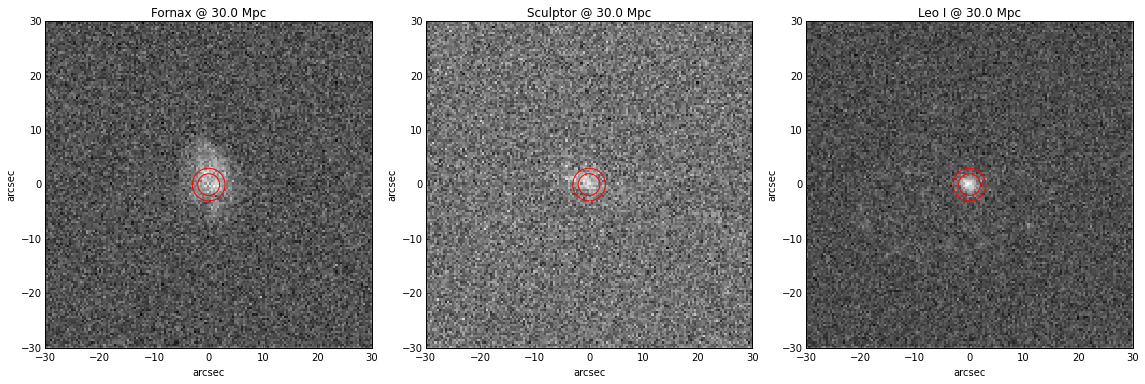

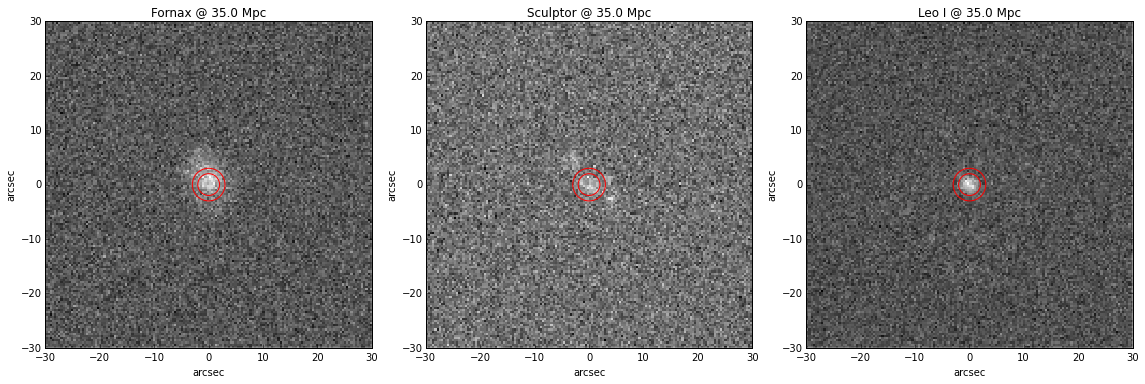

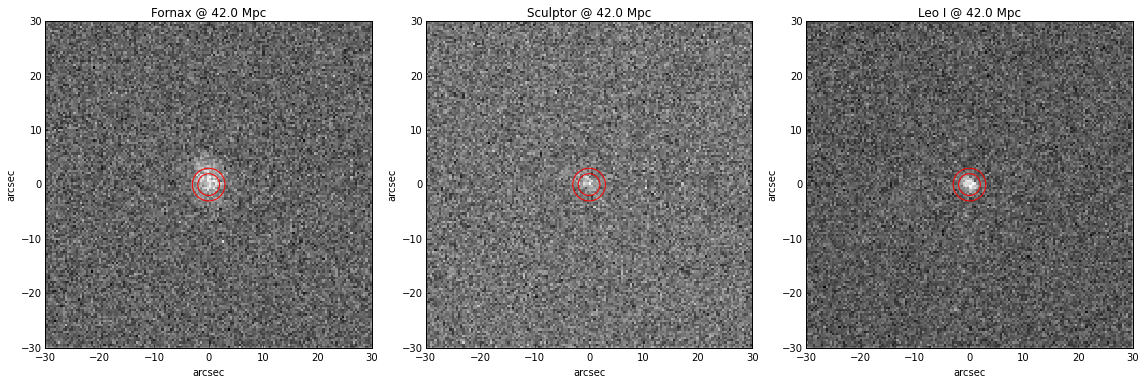

In [325]:
maxs = 10000

for d in sagadists[-3:]:
    plt.figure()

    plt.subplot(1,3,1)
    pfakeimage, fakeimage, fakeimagenosky, (xg, yg) = simulate_dwarf(fnx, fnx_coo, fnx_dist, d, fnxmsk, maxstars=maxs)
    show_fakeimage(pfakeimage, xg, yg)
    plt.title('Fornax @ {0}'.format(d))
    print('Fornax @ {0} aperture phot:{1}'.format(d, aperture_mags(fakeimagenosky)))

    plt.subplot(1,3,2)
    pfakeimage, fakeimage, fakeimagenosky, (xg, yg) = simulate_dwarf(scl, scl_coo, scl_dist, d, maxstars=maxs)
    show_fakeimage(pfakeimage, xg, yg)
    plt.title('Sculptor @ {0}'.format(d))
    print('Sculptor @ {0} aperture phot:{1}'.format(d, aperture_mags(fakeimagenosky)))

    plt.subplot(1,3,3)
    pfakeimage, fakeimage, fakeimagenosky, (xg, yg) = simulate_dwarf(leoi, leoi_coo, leoi_dist, d, maxstars=maxs)
    show_fakeimage(pfakeimage, xg, yg)
    plt.title('Leo I @ {0}'.format(d))
    print('Leo I @ {0} aperture phot:{1}'.format(d, aperture_mags(fakeimagenosky)))

    plt.tight_layout()

(205.45911288261414, 'sec for', 518831, 'stars')
Fornax @ 30.0 Mpc aperture phot:(19.581102699986232, array([ 21.43402263,  20.72129531]), array([ 1.85291993,  1.14019261]))
(102.17570114135742, 'sec for', 266799, 'stars')
Sculptor @ 30.0 Mpc aperture phot:(20.81145064616517, array([ 22.15829341,  21.66139898]), array([ 1.34684276,  0.84994833]))
(26.53728985786438, 'sec for', 70914, 'stars')
Leo I @ 30.0 Mpc aperture phot:(19.782656546567004, array([ 21.38039879,  21.02607426]), array([ 1.59774224,  1.24341771]))
(4508.040508985519, 'sec for', 518831, 'stars')
Fornax @ 35.0 Mpc aperture phot:(19.915836648139322, array([ 21.50074471,  20.82150314]), array([ 1.58490806,  0.90566649]))
(120.43996095657349, 'sec for', 266799, 'stars')
Sculptor @ 35.0 Mpc aperture phot:(21.146184594318242, array([ 22.31335318,  21.83310942]), array([ 1.16716859,  0.68692483]))
(31.287028789520264, 'sec for', 70914, 'stars')
Leo I @ 35.0 Mpc aperture phot:(20.117390494720073, array([ 21.58529474,  21.280346

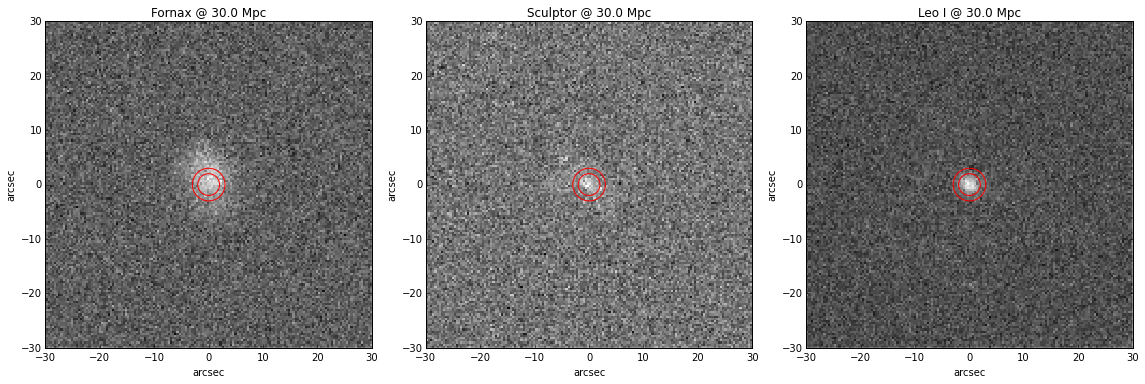

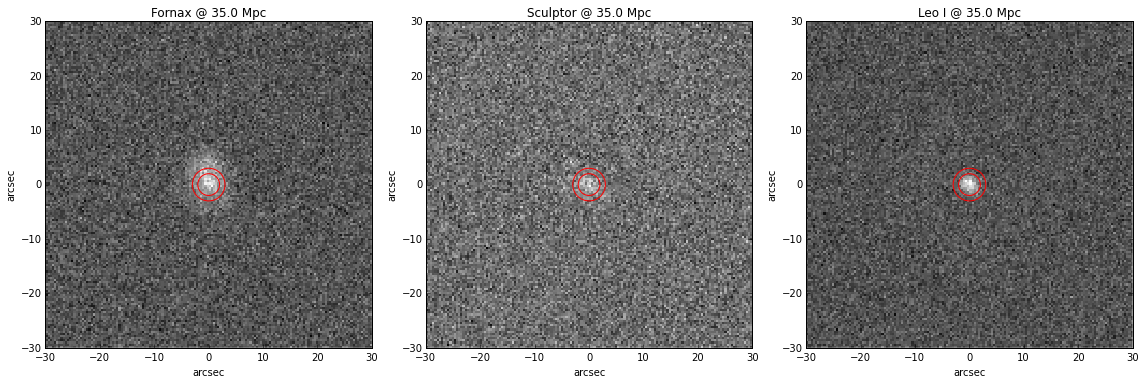

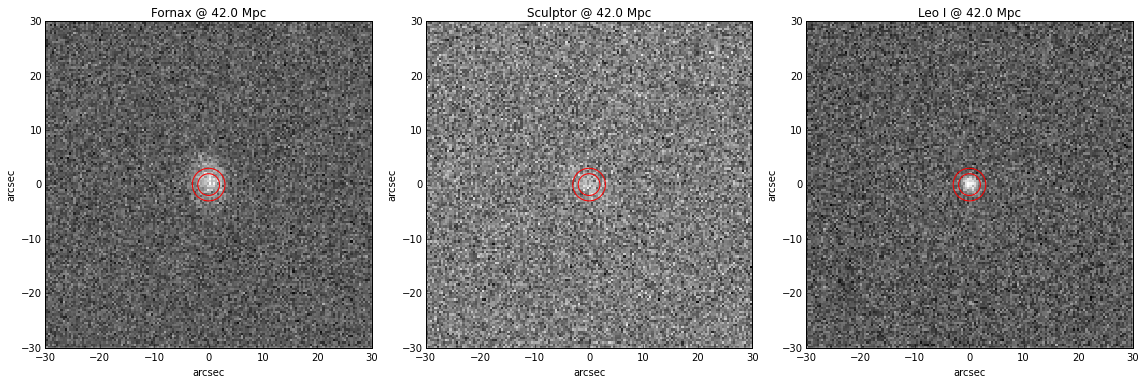

In [333]:
maxs = 1000000

for d in sagadists[-3:]:
    plt.figure()

    plt.subplot(1,3,1)
    pfakeimage, fakeimage, fakeimagenosky, (xg, yg) = simulate_dwarf(fnx, fnx_coo, fnx_dist, d, fnxmsk, maxstars=maxs)
    show_fakeimage(pfakeimage, xg, yg)
    plt.title('Fornax @ {0}'.format(d))
    print('Fornax @ {0} aperture phot:{1}'.format(d, aperture_mags(fakeimagenosky)))

    plt.subplot(1,3,2)
    pfakeimage, fakeimage, fakeimagenosky, (xg, yg) = simulate_dwarf(scl, scl_coo, scl_dist, d, maxstars=maxs)
    show_fakeimage(pfakeimage, xg, yg)
    plt.title('Sculptor @ {0}'.format(d))
    print('Sculptor @ {0} aperture phot:{1}'.format(d, aperture_mags(fakeimagenosky)))

    plt.subplot(1,3,3)
    pfakeimage, fakeimage, fakeimagenosky, (xg, yg) = simulate_dwarf(leoi, leoi_coo, leoi_dist, d, maxstars=maxs)
    show_fakeimage(pfakeimage, xg, yg)
    plt.title('Leo I @ {0}'.format(d))
    print('Leo I @ {0} aperture phot:{1}'.format(d, aperture_mags(fakeimagenosky)))

    plt.tight_layout()